## Introduction:
This is an example run through pulling 25 pages of jobs.
Parameters:
job = 'Engineer'
loctation = 'Canada'
specific jobs that were examined =
    'project engineer',
    'project manager',
    'mechanical engineer',
    'manufacturing engineer',
    'mechancial designer',
    'process engineer',
    'chemical engineer',
    'civil engineer',
    'structural engineer',
    'electrical engineer',
    'petroleum'
keywords that were searched = 
    'autocad',
    'solidworks',
    'autodesk', 
    'revit'
    
 All of these can be adjusted 




## Import packages 

In [1]:
import numpy as np
import pandas as pd
from pandas import read_html
import sqlite3

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
import datetime

## Running the scraper and word search

In [4]:
job = 'Engineer'
location = 'Canada'
main_file = '{}_{}_{}.csv'.format(job, location, datetime.datetime.now().strftime("%Y-%m-%d"))
descr_file = '{}_{}_JobDescript_{}.csv'.format(job, location, datetime.datetime.now().strftime("%Y-%m-%d"))

In [5]:
from indeed_auto_main import web_scraper
search1 = web_scraper(job,location)
search1.scrape_export_title_comp_loc_descr()

Request:560; Frequency: 0.5472441032224792 requests/s


## Import data 

In [117]:
df = pd.read_csv(main_file,header=None)

In [118]:
df.columns= ['Job_Id','Company', 'JobTitle', 'Location']

In [127]:
#Drop duplicate entries
df = df.drop_duplicates(subset=['Company','JobTitle','Location'])

In [129]:
df.head()

,Job_Id,Company,JobTitle,Location
0,1,lenano diagnostics,r&d engineer / supervisor,"waterloo, on"
1,2,bloom recruitment,systems engineer,"vancouver, bc"
2,3,vanrx pharmasystems,manufacturing engineer,"vancouver, bc"
3,4,expleo,hvac system engineer,"saint-bruno-de-montarville, qc"
4,5,noreast electronics,electrical engineer,"hawkesbury, on"


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 559
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Job_Id    296 non-null    int64 
 1   Company   296 non-null    object
 2   JobTitle  296 non-null    object
 3   Location  296 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


In [131]:
# Cleaning up some normal outlier entries
df = df.replace('remote','canada')
df = df.replace('montréal, qc','montreal, qc')
df = df.replace('greater toronto area','toronto')
df = df.replace('greater toronto area, on','toronto')
df = df.replace('british columbia','bc')
df = df.replace('alberta','ab')
df = df.replace('saskatchewan','sk')
df = df.replace('manitoba','mn')
df = df.replace('ontario','on')
df = df.replace('newfoundland and labrador','nl')

In [132]:
# Creating new columns for City/Province
df['City'] = df.apply(lambda row: row['Location'].split(',')[0], axis=1)
df['Province'] = df.apply(lambda row: row['Location'].split(',')[1] if len(row['Location'].split(',')) > 1 else row['Location'], axis=1)

## Getting gps coord for locations

In [133]:
# Creating a list of locations as well as a column that will represent the location count

Location_group = df.groupby('Location').count()
Location_group.reset_index(inplace=True)
Location_group.sort_values(by='Company')

df['location_count'] = df.groupby('Location')['Location'].transform('count')

location_list = Location_group['Location'].tolist()

In [134]:
# Create a list of locations that are not in the sqlite database 

conn = sqlite3.connect('LocationLatLong.db')
c = conn.cursor()

c.execute(''' SELECT count(name) FROM sqlite_master WHERE type='table' AND name='LocationLatLong' ''')

if c.fetchone()[0]==1:
    Location_database_df = pd.read_sql_query("SELECT location FROM LocationLatLong", conn)
    Location_database_df_list = Location_database_df['location'].tolist()

    missing_locations = []
    for location in location_list:
        if location not in Location_database_df_list:
            missing_locations.append(location)
            
else:
    missing_locations = Location_database_df_list

In [135]:
# Check if there are new locations not in the sqlite database
# If there are missing locations:
    # Go through the geopy process of getting lat/long for each missing location
    # Create an updated df with the location lat/longs 
    # Merge this onto existing database 
# If there are no missing locations:
    # Create a df from the existing database 

if len(missing_locations) != 0:  
    import certifi
    import ssl
    import geopy
    from geopy.geocoders import Nominatim
    from time import sleep
    ctx = ssl.create_default_context(cafile=certifi.where())
    geopy.geocoders.options.default_ssl_context = ctx

    #Initialize lat and long
    long = []
    lat = []
    
    #Iterate through the values and append in any missing locations to the database
    #For each new location, find the lat and long
    for location in missing_locations:
        geolocator = Nominatim(user_agent = 'personal', scheme='http',timeout=20)
        location = geolocator.geocode(location)
        lat.append(location.latitude)
        long.append(location.longitude)
        sleep(2)
    
    #Create a new dataframe with the location/lat/long
    New_LocationLatLong_df = pd.DataFrame(
        {'location': missing_locations,
         'lat': lat,
         'long': long
        })

    #Initialize sql connection
    conn = sqlite3.connect('LocationLatLong.db')
    c = conn.cursor()
    
    #Create a table if does not exist
    c.execute('''CREATE TABLE IF NOT EXISTS LocationLatLong
                 ([generated_id] INTEGER PRIMARY KEY,[location] text, [lat] integer, [long] integer)''')
    
    #Append new values to table
    New_LocationLatLong_df.to_sql('LocationLatLong', conn, if_exists='append', index = False)  
    
    
# If there are no new values, create a dataframe from existing table   

conn = sqlite3.connect('LocationLatLong.db')
LocationLatLong_df = pd.read_sql_query("SELECT * FROM LocationLatLong", conn)

Merging lat/long to main df 

In [136]:
df.head()

,Job_Id,Company,JobTitle,Location,City,Province,location_count
0,1,lenano diagnostics,r&d engineer / supervisor,"waterloo, on",waterloo,on,3
1,2,bloom recruitment,systems engineer,"vancouver, bc",vancouver,bc,15
2,3,vanrx pharmasystems,manufacturing engineer,"vancouver, bc",vancouver,bc,15
3,4,expleo,hvac system engineer,"saint-bruno-de-montarville, qc",saint-bruno-de-montarville,qc,4
4,5,noreast electronics,electrical engineer,"hawkesbury, on",hawkesbury,on,1


In [137]:
LocationLatLong_df.head()

,generated_id,location,lat,long
0,1,"abbotsford, bc",49.052116,-122.329479
1,2,"acheson, ab",53.545914,-113.771576
2,3,alberta,55.001251,-115.002136
3,4,"alliston, on",44.153460,-79.869157
4,5,"altona, mb",49.103111,-97.558361


In [138]:
lat_dict = LocationLatLong_df.set_index('location')['lat'].to_dict()
long_dict = LocationLatLong_df.set_index('location')['long'].to_dict()

In [139]:
df['lat'] = df['Location'].map(lat_dict)
df['long'] = df['Location'].map(long_dict)

In [140]:
df.head()

,Job_Id,Company,JobTitle,Location,City,Province,location_count,lat,long
0,1,lenano diagnostics,r&d engineer / supervisor,"waterloo, on",waterloo,on,3,43.466874,-80.524635
1,2,bloom recruitment,systems engineer,"vancouver, bc",vancouver,bc,15,49.260872,-123.113953
2,3,vanrx pharmasystems,manufacturing engineer,"vancouver, bc",vancouver,bc,15,49.260872,-123.113953
3,4,expleo,hvac system engineer,"saint-bruno-de-montarville, qc",saint-bruno-de-montarville,qc,4,45.525616,-73.339180
4,5,noreast electronics,electrical engineer,"hawkesbury, on",hawkesbury,on,1,45.610281,-74.605561


In [141]:
# Creating a df from the population info

pop_df = pd.read_csv('Population.csv')
pop_df = pop_df.drop('location',axis=1)
pop_df['asciiname'] = pop_df['asciiname'].str.lower()
pop_df.head()

,asciiname,population
0,toronto,2600000
1,montreal,1600000
2,calgary,1019942
3,ottawa,812129
4,edmonton,712391


In [142]:
# Merging this onto the main df

pop_dict = pop_df.set_index('asciiname')['population'].to_dict()
df['population'] = df['City'].map(pop_dict)

In [143]:
df.head()

,Job_Id,Company,JobTitle,Location,City,Province,location_count,lat,long,population
0,1,lenano diagnostics,r&d engineer / supervisor,"waterloo, on",waterloo,on,3,43.466874,-80.524635,97475.0
1,2,bloom recruitment,systems engineer,"vancouver, bc",vancouver,bc,15,49.260872,-123.113953,600000.0
2,3,vanrx pharmasystems,manufacturing engineer,"vancouver, bc",vancouver,bc,15,49.260872,-123.113953,600000.0
3,4,expleo,hvac system engineer,"saint-bruno-de-montarville, qc",saint-bruno-de-montarville,qc,4,45.525616,-73.339180,24388.0
4,5,noreast electronics,electrical engineer,"hawkesbury, on",hawkesbury,on,1,45.610281,-74.605561,12283.0


## Visualization

In [144]:
# Interactive location plot

import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 

data = [
        go.Scattergeo(
        locationmode = 'country names',
        lon = df['long'],
        lat = df['lat'],
        text = df['Location']+', '+df['location_count'].astype('str'),
        mode = 'markers',
        marker = dict( 
            size = df['location_count'],
            colorscale= 'Viridis',  
            color = df['location_count'],
            colorbar = dict(
                title = 'Job_Count',
                titleside = 'top',
                tickmode = 'array',
        )))]

layout = dict(
        title = 'Job locations', 
        autosize=True,
        geo = dict(
            scope='north america',
            projection=dict(type = 'equirectangular'),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5        
        ),
    )

fig = go.Figure(data = data, layout = layout)
iplot(fig,validate=False)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

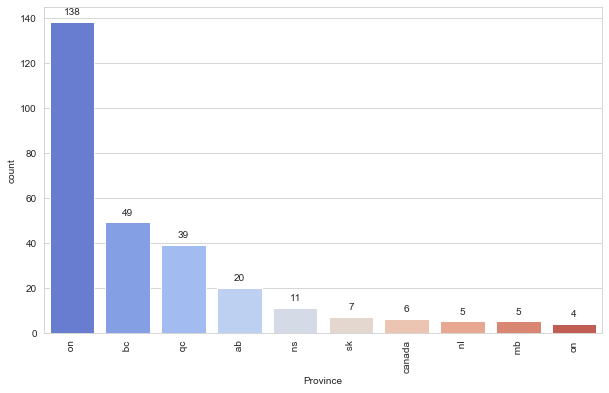

In [145]:
# Plot of postings per province (top 10)

plt.figure(figsize=(10,6))
splot = sns.countplot('Province', data=df, order = df['Province'].value_counts().iloc[:10].index, palette = 'coolwarm')

for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

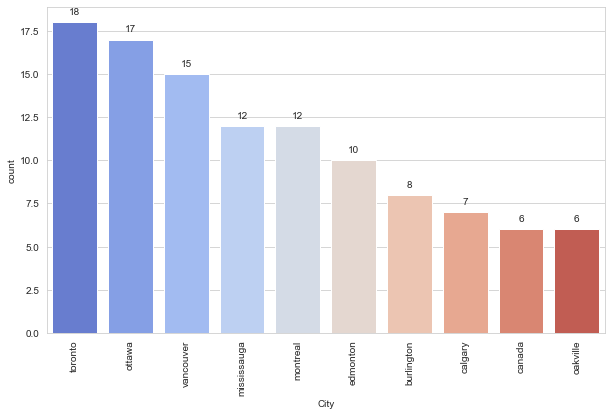

In [146]:
# Plot of postings per city (top 10)

plt.figure(figsize=(10,6))
splot = sns.countplot('City', data=df, order = df['City'].value_counts().iloc[:10].index, palette='coolwarm')

for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

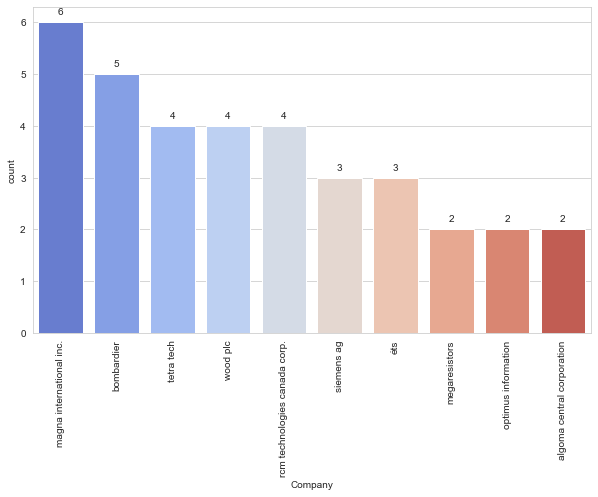

In [147]:
# Plot of postings per Company (top 10)

plt.figure(figsize=(10,6))
splot = sns.countplot('Company', data=df, order = df['Company'].value_counts().iloc[:10].index, palette='coolwarm')

for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xticks(rotation=90)

In [148]:
jobs_to_search = [
    'project engineer',
    'project manager',
    'mechanical engineer',
    'manufacturing engineer',
    'mechancial designer',
    'process engineer',
    'chemical engineer',
    'civil engineer',
    'structural engineer',
    'electrical engineer',
    'petroleum'
]

d = {el:0 for el in jobs_to_search}

def job_search(df):
    for job in df['JobTitle']:
        for search_job in jobs_to_search:
            if search_job in job:
                d[search_job] = d[search_job]+1
    job_counts = pd.DataFrame(d,index=[1])
    return job_counts.transpose().reset_index().sort_values(by=1,ascending=False).rename(columns={'index':'Job',1:'Count'})

job_search_df = job_search(df)

(0, 50)

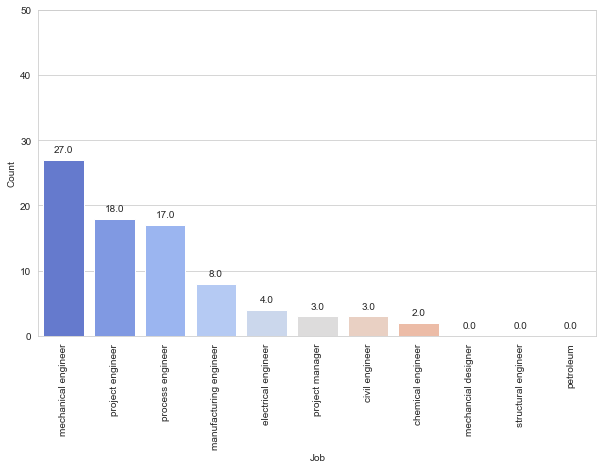

In [150]:
plt.figure(figsize=(10,6))
splot = sns.barplot(x=job_search_df['Job'],y=job_search_df['Count'], palette='coolwarm')

for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xticks(rotation=90)
plt.ylim(0,50)

In [154]:
keywords_to_search = [
    'autocad',
    'solidworks',
    'autodesk', 
    'revit']

from text_breakdown import word_search

In [155]:
search1 = word_search(keywords_to_search,descr_file)
search_values = search1.complete()


560 jobs have been searched. The result is:

{'autocad': 81, 'solidworks': 73, 'autodesk': 5, 'revit': 5}


(0, 100)

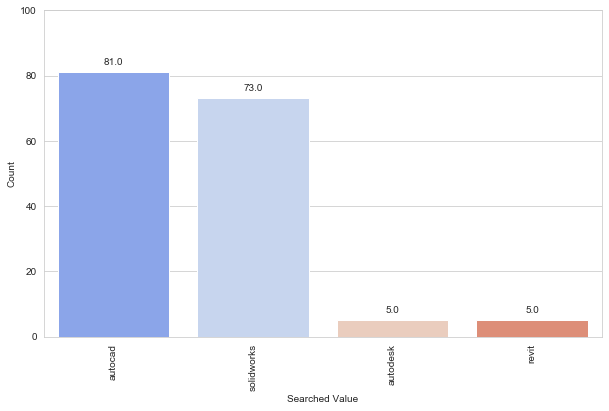

In [156]:
search_value_df = pd.DataFrame(search_values,index=[1])
search_value_df = search_value_df.transpose().reset_index().rename(columns={'index':'Searched Value',1:'Count'})

plt.figure(figsize=(10,6))
splot = sns.barplot(x=search_value_df['Searched Value'],y=search_value_df['Count'], palette='coolwarm')

for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xticks(rotation=90)
plt.ylim(0,100)
